# ResNet34 Clustering

In [1]:
from src.DataLoader.load_lfw import load_lfw
from src.FaceRecogniser.ResNet34.TSNE import plot_TSNE
from src.DataLoader.load_A2 import load_A2

In [2]:
import face_recognition
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
train_filepaths, train_labels, test_filepaths, test_labels = load_lfw()

In [4]:
filepaths = train_filepaths + test_filepaths
labels = train_labels + test_labels

In [5]:
# filepaths, labels = load_A2()

### ResNet-34 encoding

In [6]:
def encode(filepaths, labels):
    labels = np.array(labels)
    filepaths = np.array(filepaths)
    no_face_c = 0
    X = np.zeros((len(filepaths), 128))
    for i, filepath in enumerate(filepaths):
        img = face_recognition.load_image_file(filepath)
        encodings = face_recognition.face_encodings(img)
        # ToDo: Some cropped images won't look like a face to ReseNet-34
        if not encodings:
            no_face_c += 1
            continue
            
        X[i] = np.array(encodings)
    print(f'No encodings found for {no_face_c} faces.')
    return X[(X != 0).all(axis = 1)], labels[(X != 0).all(axis = 1)]

In [7]:
X, y = encode(filepaths, labels)

No encodings found for 10 faces.


### Evaluation Metrics

**Input:**  
Feature matrix $X \in \mathbb R^{n\times m}$  
such that there are $n$ samples and $m$ features.  

Ground truth $y \in \mathbb N^c$  
such that there are c unique class labels. Thus $c\leq n$

**Evaluation process:**  


For an image $x_i\in X$, a class prediction is made: $p_i \in \mathbb N^c$  
The members of the predicted class are named by their indices:  
$pm_i = \{j|p_j = p_i \forall j \in \mathbb N^n\}$   


Similarly, for each ground truth label $y_i$ there exists a set of indices at which members of the same class as $y_i$ are found:  
$ym_i = \{k|y_k = y_i \forall k \in \mathbb N^n\}$  


Now, $pm_i$ is the set of predicted "same class" indices that the algorithm predicts should belong to image $x_i$ and $ym_i$ is the set of indices that belong to the same class as point $x_i$ according to the ground truth.  


$$tp = pm_i \cap ym_i$$
$$fp = pm_i \setminus ym_i$$
$$fn = ym_i \setminus pm_i$$
$$tn = n - tp - fp - fn$$

<img src="venn.png" style="display: block; margin-left:auto; margin-right: auto; width: 50%">  

These values are accumulated over all samples $i\in \mathbb N^n$.

In [8]:
def jaccard(tp, fp, fn):
    return tp / (tp + fp + fn)
    
def accuracy(tp, fp, fn, tn):
    return (tp + tn)/(tp + fp + fn + tn)

def precision(tp, fp):
    return tp/(tp + fp)

def recall(tp, fn):
    return tp/(tp + fn)

def f1(tp, fp, fn):
    p = precision(tp, fp)
    r = recall(tp, fn)
    return 2 * p * r / (p + r)

def evaluate(y, pred, verbose = True):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for true_label, pred_label in zip(y, pred):
        true_idx = {i for i, t in enumerate(y) if t == true_label}
        pred_idx = {i for i, p in enumerate(pred) if p == pred_label}
        tp += len(pred_idx.intersection(true_idx))
        fp += len(pred_idx.difference(true_idx))
        fn += len(true_idx.difference(pred_idx))
        tn += len(y) - len(pred_idx.intersection(true_idx)) -len(pred_idx.difference(true_idx)) - len(true_idx.difference(pred_idx))
    if verbose:
        print(f'Accuracy:  {accuracy(tp, fp, fn, tn):>8.2%}')
        print(f'Jaccard:   {jaccard(tp, fp, fn):>8.2%}')
        print(f'Precision: {precision(tp, fp):>8.2%}')
        print(f'Recall:    {recall(tp, fn):>8.2%}')
        print(f'F1:        {f1(tp, fp, fn):>8.2%}')
    else:
        return precision(tp, fp), recall(tp, fn)

### Precision Recall Curve
Will be used to determine optimal clustering parameters

In [9]:
def plot_prec_rec(clf, thresholds):
    """
    Evaluates a classifier that takes one argument (thresh) over a range of thresholds
    """
    fig, ax = plt.subplots(figsize = (20,8))
    prec = []
    rec = []
    for thresh in thresholds:
        preds = clf(thresh)
        p, r = evaluate(y, preds, False)
        prec.append(p)
        rec.append(r)

    plt.plot(prec, rec)
    plt.xlabel('Precision', size = 20)
    plt.ylabel('Recall', size = 20)
    plt.grid()

    for i in range(len(prec)):
        ax.annotate(f'{thresholds[i]:.2f}', (prec[i], rec[i]))

### DBScan
The choice of Eps is 0.5 by default. However, if the dataset contains many people that belong together, then another eps may be optimal.  

eps := 
`The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.`


In [18]:
from sklearn.cluster import DBSCAN

cls = DBSCAN(eps = 0.5, min_samples = 1)
pred = cls.fit_predict(X)
evaluate(y, pred)

Accuracy:    99.69%
Jaccard:     78.59%
Precision:   85.00%
Recall:      91.24%
F1:          88.01%


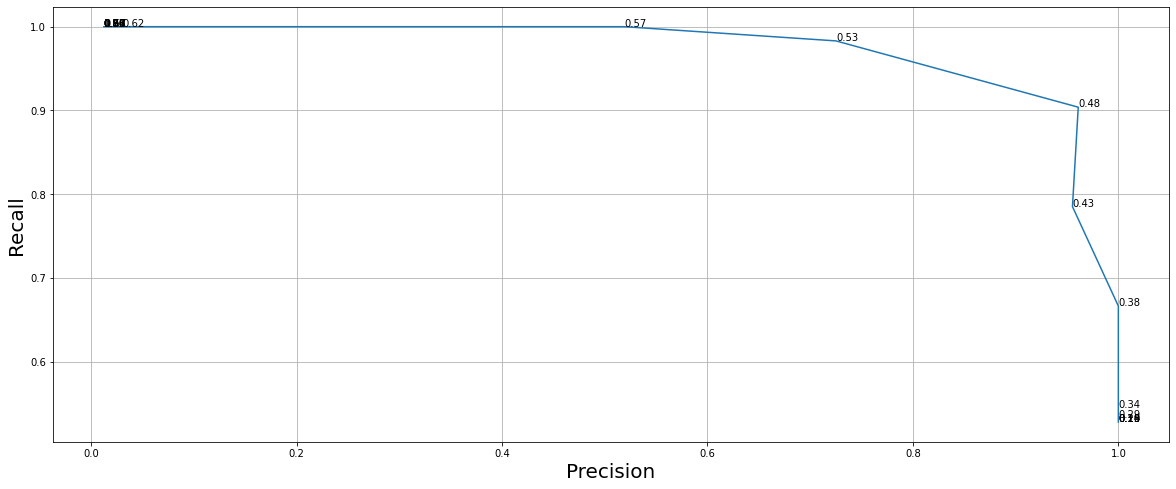

In [11]:
def db_scan_depending_on_eps(eps):
    cls = DBSCAN(eps = eps, min_samples = 1)
    pred = cls.fit_predict(X)
    return pred

plot_prec_rec(db_scan_depending_on_eps, thresholds = np.linspace(0.1,1,20))

### Verification of results: TSNE
Visually inspect where mistakes are being made

In [12]:
purity = []
for true_label, pred_label in zip(y, pred):
    true_idx = {i for i, t in enumerate(y) if t == true_label}
    pred_idx = {i for i, p in enumerate(pred) if p == pred_label}
    purity.append(len(pred_idx.intersection(true_idx))/ len(true_idx))

In [13]:
color_palette = sns.color_palette('Reds', 5)
color_idx = [int(5*(1-p)) for p in purity]
colors = [color_palette[i] for i in color_idx]

In [14]:
# %matplotlib qt
# plot_TSNE(X, y, colors)

## Other Clustering algorithms
And why they are not as good as DBScan

### Kmeans
Not applicable as the number of clusters "k" cannot be known ahead of time

### Agglomerative Clustering: Ward

In [15]:
from sklearn.cluster import AgglomerativeClustering

In [16]:
clf = AgglomerativeClustering(n_clusters = None, distance_threshold = 0.32)
clf.fit(X)
preds = clf.labels_
evaluate(y, preds)

Accuracy:    99.43%
Jaccard:     53.39%
Precision:  100.00%
Recall:      53.39%
F1:          69.61%


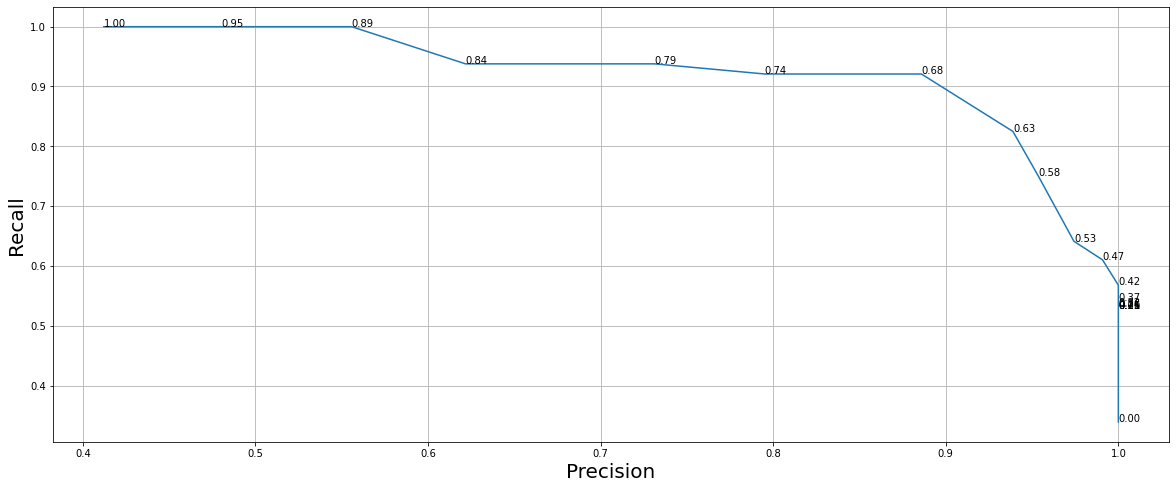

In [17]:
def agg_clustering(thresh):
    clf = AgglomerativeClustering(n_clusters = None, distance_threshold = thresh)
    clf.fit(X)
    preds = clf.labels_
    return preds

plot_prec_rec(agg_clustering, thresholds = np.linspace(0,1,20))